In [ ]:
%run -n main.py

In [ ]:
# lines = read_lines(DOTENV_PATH)
# env = dict(parse_dotenv(lines))
# openai.api_key = env['OPENAI_TOKEN']

# tasks

In [ ]:
table = pd.read_csv('tasks/ru_user_oriented.csv')
table = table[~table.done.isnull()]
table = table.where(pd.notnull(table), None)
table = table[['id', 'instruction', 'input']]
ru_user_oriented_items = table.to_dict(orient='records')

# evals

## llama_7b_ru_turbo_alpaca_lora

In [ ]:
# LLM.int8() requires Turing or Ampere GPUs.
# WARNING: No libcudart.so found! Install CUDA or the cudatoolkit package (anaconda)!
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.7/targets/x86_64-linux/lib'

import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

model_name = 'IlyaGusev/llama_7b_ru_turbo_alpaca_lora'

config = PeftConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,

    # Overriding torch_dtype=None with `torch_dtype=torch.float16
    torch_dtype=torch.float16,
    
    # A device map needs to be passed to run convert models into mixed-int8
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = PeftModel.from_pretrained(model, model_name)

In [ ]:
%run -n main.py
lines = read_lines('evals/gusev_7b_ru_alpaca_lora.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_ru_alcapa_prompt(item)
    output = ru_alpaca_complete(prompt, model, tokenizer)
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/gusev_7b_ru_alpaca_lora.jsonl', lines)

## llama_13b_ru_turbo_alpaca_lora

In [ ]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-11.7/targets/x86_64-linux/lib'

import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

model_name = 'IlyaGusev/llama_13b_ru_turbo_alpaca_lora'

config = PeftConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map='auto'
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = PeftModel.from_pretrained(model, model_name)

In [ ]:
%run -n main.py
lines = read_lines('evals/gusev_13b_ru_alpaca_lora.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_ru_alcapa_prompt(item)
    output = ru_alpaca_complete(prompt, model, tokenizer)
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/gusev_13b_ru_alpaca_lora.jsonl', lines)

## instruct_rugptlarge

In [ ]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

model_name = 'AlexWortega/instruct_rugptlarge'

tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
special_tokens_dict = {
    'additional_special_tokens': [
        '<code>', '</code>',
        '<instructionS>', '<instructionE>',
        '<next>'
    ]
}
tokenizer.add_special_tokens(special_tokens_dict)

In [ ]:
device = 'cuda:0'
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
%run -n main.py
lines = read_lines('evals/wortega_instruct_rugpt_large.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_instruct_rugpt(item)
    output = instruct_rugpt_complete(prompt, model, tokenizer)
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/wortega_instruct_rugpt_large.jsonl', lines)

## gpt-3.5-turbo

In [ ]:
lines = read_lines('evals/openai_turbo.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_openai_prompt(item)
    output = openai_chat_complete(prompt, model='gpt-3.5-turbo')
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/openai_turbo.jsonl', lines)

## text-davinci-003

In [ ]:
lines = read_lines('evals/openai_davinci_003.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_openai_prompt(item)
    output = openai_complete(prompt, model='text-davinci-003')
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/openai_davinci_003.jsonl', lines)

## text-davinci-002

In [ ]:
lines = read_lines('evals/openai_davinci_002.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_openai_prompt(item)
    output = openai_complete(prompt, model='text-davinci-002')
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/openai_davinci_002.jsonl', lines)

## davinci-001

In [ ]:
lines = read_lines('evals/openai_davinci_001.jsonl')
eval_items = list(parse_jsonl(lines))
cache_ids = {_['id'] for _ in eval_items}

In [ ]:
items = [
    _ for _ in ru_user_oriented_items
    if _['id'] not in cache_ids
]
for item in log_progress(items):
    prompt = user_oriented_openai_prompt(item)
    output = openai_complete(prompt, model='davinci')
    item = {
        'id': item['id'],
        'prompt': prompt,
        'output': output
    }
    eval_items.append(item)

In [ ]:
%run -n main.py
lines = format_jsonl(eval_items)
write_lines('evals/openai_davinci_001.jsonl', lines)

# annot

In [75]:
!ls evals

gusev_13b_ru_alpaca_lora.jsonl     openai_davinci_003.jsonl
gusev_7b_ru_alpaca_lora.jsonl      openai_turbo.jsonl
openai_davinci_001.jsonl           wortega_instruct_rugpt_large.jsonl
openai_davinci_002.jsonl


In [89]:
%run -n main.py
a_name = 'openai_davinci_003'
b_name = 'openai_turbo'

lines = read_lines(f'evals/{a_name}.jsonl')
a_items = list(parse_jsonl(lines))

lines = read_lines(f'evals/{b_name}.jsonl')
b_items = list(parse_jsonl(lines))

In [90]:
import pandas as pd

id_a_items = {_['id']: _ for _ in a_items}
id_b_items = {_['id']: _ for _ in b_items}
items = []
for id in sorted(id_a_items.keys() & id_b_items.keys()):
    a_item = id_a_items[id]
    b_item = id_b_items[id]

    items.append({
        'id': id,
        'prompt': b_item['prompt'],
        'a': a_item['output'],
        'b': b_item['output'],
        'label': None
    })

table = pd.DataFrame(items)
table.to_excel(f'sbs/{a_name}_{b_name}.xlsx', index=False)

# report

In [129]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

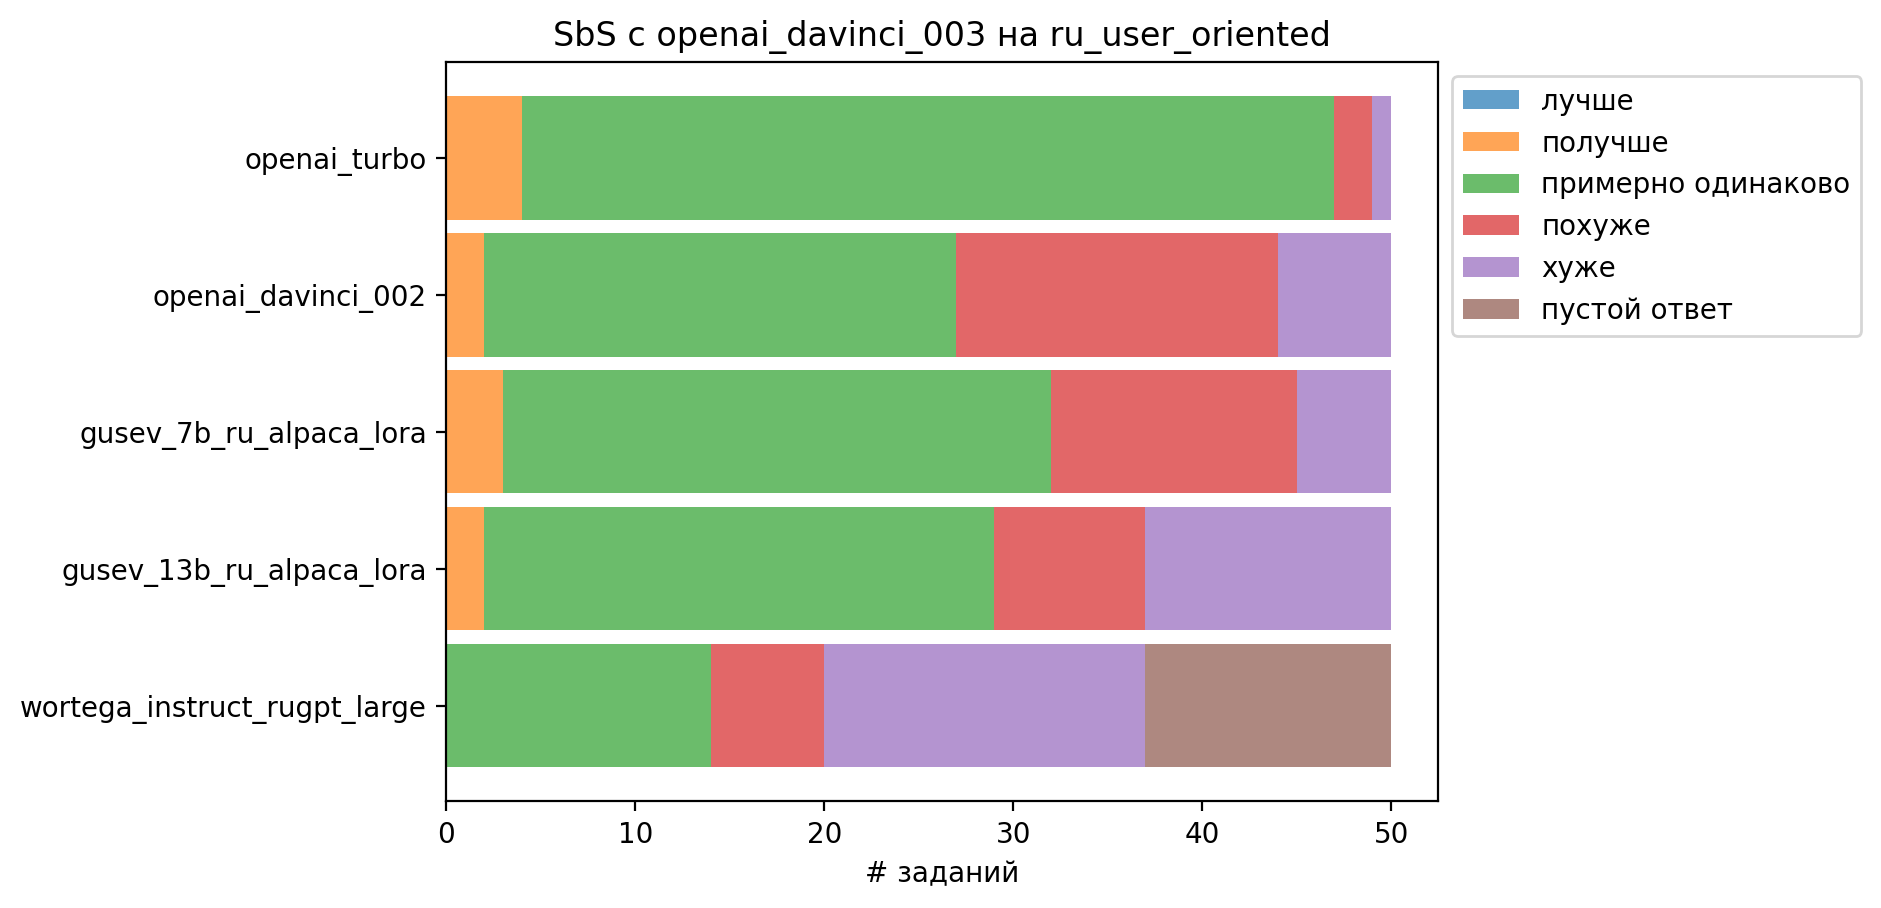

In [152]:
from pathlib import Path

names = [
    'openai_turbo',
    'openai_davinci_002',
    'gusev_7b_ru_alpaca_lora',
    'gusev_13b_ru_alpaca_lora',
    'wortega_instruct_rugpt_large',
]


data = {}
for name in names:
    path = f'sbs/openai_davinci_003_{name}.xlsx'
    table = pd.read_excel(path, dtype='str')
    
    label_counts = table[:50].label.value_counts()
    for label, count in label_counts.items():
        data[name, label] = count
        
# data['openai_davinci_003', '0'] = 30

table = pd.Series(data)
table = table.unstack()
table = table.fillna(0)


table = table.reindex(
    index=[
        'wortega_instruct_rugpt_large',

        'gusev_13b_ru_alpaca_lora',
        'gusev_7b_ru_alpaca_lora',

        'openai_davinci_002',
        'openai_turbo',
        
    ],
    columns=[
        '2', '1', '0', '-1', '-2', '?',
    ]
    
)
table = table.rename(
    columns = {
        '?': 'пустой ответ',
        '-2': 'хуже',
        '-1': 'похуже',
        '0': 'примерно одинаково',
        '1': 'получше',
        '2': 'лучше'
    }
)


table.plot(
    title='SbS с openai_davinci_003 на ru_user_oriented',
    kind='barh',
    stacked=True,
    width=0.9,
    alpha=0.7,
    xlabel='# заданий'
).legend(
    loc='upper left',
    bbox_to_anchor=(1.0, 1.0)
)

In [150]:
!open sbs